In [31]:
### DATA-DRIVEN DIAGNOSTICS I ###
### GENERATE DATA FOR DATA-DRIVEN MODEL ###

import random
from prog_models.models import BatteryCircuit
import pandas as pd
import warnings

# Ignore warnings when machine exceeds its end of life
warnings.filterwarnings("ignore")

""" Method that uses a physical machine model from the prog_models package and a current (health) state of the model and
an action (i.e., intensity), which is performed for 100 time steps
    Parameter:
        machine             machine model from the prog_models package
        state               current (health) state of the model
        action              loading of the machine for the next 100 time steps
    Return:
        health                               
    """
def produce_model(machine, states, action):
        
        # Define load of battery
        def future_loading(t, x=None):
            return {'i': action}

        # Set current state of machine
        machine.parameters['x0'] = states
        # Simulate 100 steps
        options = {
            'save_freq': 100,  # Frequency at which results are saved
            'dt': 2  # Timestep
        }
        (_, _, states, outputs, event_states) = machine.simulate_to(100, future_loading, **options)
        health = event_states[-1]['EOD']
        return(round(health, 2), states[-1], outputs[-1]['t'], outputs[-1]['v'])
def reset_states(machine):
    # Returns initial states of machine, e.g., {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0} for Battery
    return(machine.default_parameters['x0'])
   
for pn in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: 
    for mn in [0]:
        print('Process noise = ' + str(0.1*pn) + ', Measurement noise = ' + str(0.1*mn))
        battery = BatteryCircuit(process_noise = 0.1*pn, measurement_noise = 0.1*mn)
        states = reset_states(battery)
        reset_counter = 0
        dataset = []
        for i in range(int(1e4)):
            # If asset failed last period, reset all historical values
            if reset_counter == 0: t = v = t_1 = v_1 = t_2 = v_2 = t_3 = v_3 = 0 
            # Shift history by one time period
            v_3 = v_2
            t_3 = t_2
            v_2 = v_1
            t_2 = t_1
            v_1 = v
            t_1 = t

            # Increment reset_counter
            reset_counter = reset_counter + 1
            # Compute new health, states, t, and v using last battery state and a random new action
            health, states, t, v = produce_model(machine=battery, states=states, action=random.sample((0, 1, 2, 3, 4), 1)[0])
            
            if health <= 0: 
                # Reset battery states to initialize battery for next produce_model call
                states = reset_states(battery)
                # Initialize reset_counter
                reset_counter = 0
                # Sometimes produce_model returns weird or negative values as the end of life is exceeded
                # Here, we just simply set it to zero to not confuse a later learner 
                health = 0

            # append to two-dimensional list
            dataset.append([t, v, t_1, v_1, t_2, v_2, t_3, v_3, health])

        # Transform two-dim list to dataframe
        dataset = pd.DataFrame(dataset, columns=['t', 'v', 't_1', 'v_1', 't_2', 'v_2', 't_3', 'v_3', 'health'])
        # Denote machine runs to-failure with incrementing id
        k = 0
        for i in range(dataset.shape[0]):
            if (dataset.iloc[i]['t_1'] == 0 and dataset.iloc[i]['v_1'] == 0):
                j = 1
                k = k + 1
            dataset.loc[i, 'time'] = j
            j = j + 1
            dataset.loc[i, 'ID'] = k
        dataset = dataset.sort_values(['ID', 'time'], ascending=[True, False])
        # Assign RUL by counting upwards per serial number in the descended data frame
        dataset['RUL'] = dataset.groupby((dataset['ID'] != dataset['ID'].shift(1)).cumsum()).cumcount()
        dataset = dataset.sort_values(['ID', 'time'], ascending=True)

        # Save it as pickle
        dataset.to_pickle('diagnostics/data_' + 'pn' + str(pn) + '_mn' + str(mn))

Process noise = 0.0, Measurement noise = 0.0
Process noise = 0.1, Measurement noise = 0.0
Process noise = 0.2, Measurement noise = 0.0
Process noise = 0.30000000000000004, Measurement noise = 0.0
Process noise = 0.4, Measurement noise = 0.0
Process noise = 0.5, Measurement noise = 0.0
Process noise = 0.6000000000000001, Measurement noise = 0.0
Process noise = 0.7000000000000001, Measurement noise = 0.0
Process noise = 0.8, Measurement noise = 0.0
Process noise = 0.9, Measurement noise = 0.0
Process noise = 1.0, Measurement noise = 0.0


In [1]:
# Model based on RUL (prognostics = True) or health (diagnostics, prognostics = False)
prognostics = False

In [6]:
### DATA-DRIVEN DIAGNOSTICS II ###
### FIT AND TEST MODEL ###
from sklearn import tree, linear_model, kernel_ridge, svm, neighbors, gaussian_process, ensemble, neural_network
import pandas as pd
from sklearn.model_selection import cross_validate
import pickle
import numpy as np

score_data = []
for pn in [0, 1, 2, 3, 4, 5, 6, 7 , 8, 9, 10]: 
    for mn in [0]:
        print('Process noise = ' + str(0.1*pn) + ', Measurement noise = ' + str(0.1*mn))
        dataset = pd.read_pickle('diagnostics/data_' + 'pn' + str(pn) + '_mn' + str(mn))
        X = dataset[['t', 'v', 't_1', 'v_1', 't_2', 'v_2', 't_3', 'v_3']]
        if prognostics:
            y = dataset['RUL']
        else:
            y = dataset['health']
        learner = ensemble.RandomForestRegressor()
        scoring = {'r2': 'r2',
                    'mae': 'neg_mean_absolute_error',
                    'mape': 'neg_mean_absolute_percentage_error',
                    'rmse': 'neg_root_mean_squared_error'}
        scores = cross_validate(learner, X, y, scoring=scoring, cv=5) # default scoring R2
        print("R2: " + str(scores['test_r2']))
        print("mae: " + str(scores['test_mae']))
        print("mape: " + str(scores['test_mape']))
        print("rmse: " + str(scores['test_rmse']))
        # Store measures
        score_data.append(['model_' + 'pn' + str(pn) + '_mn' + str(mn), np.mean(scores['test_r2']),
                            np.mean(scores['test_mae']), np.mean(scores['test_mape']), np.mean(scores['test_rmse'])])

        # Fit on all data
        model = ensemble.RandomForestRegressor().fit(X, y)
        if prognostics:
            pickle.dump(model, open('prognostics/model_' + 'pn' + str(pn) + '_mn' + str(mn), 'wb'))
        else:
            pickle.dump(model, open('diagnostics/model_' + 'pn' + str(pn) + '_mn' + str(mn), 'wb'))
# Transform two-dim list to dataframe
score_df = pd.DataFrame(score_data, columns=['model', 'r2', 'mae', 'mape', 'rmse'])
if prognostics:
    score_df.to_excel("prognostics/scores.xlsx") 
else:
    score_df.to_excel("diagnostics/scores.xlsx") 

Process noise = 0.0, Measurement noise = 0.0
R2: [0.98346924 0.97869884 0.98271119 0.98084096 0.98029931]
mae: [-0.0186088  -0.02097155 -0.01949765 -0.0201391  -0.0208858 ]
mape: [-7.86658635e-02 -3.23583633e+11 -9.00719925e+09 -9.20286148e-02
 -1.71587146e+11]
rmse: [-0.03669848 -0.04135376 -0.03768967 -0.03960828 -0.04014499]
Process noise = 0.1, Measurement noise = 0.0
R2: [0.94511725 0.94338909 0.94308702 0.95269309 0.92781427]
mae: [-0.04355035 -0.0430732  -0.0434886  -0.0409953  -0.04892035]
mape: [-1.57625987e+09 -6.75539944e+09 -2.31935381e+10 -3.03992975e+10
 -3.69295169e+11]
rmse: [-0.06585241 -0.06812947 -0.06765209 -0.06181947 -0.07649472]
Process noise = 0.2, Measurement noise = 0.0
R2: [0.89160295 0.90719555 0.90106071 0.89986382 0.8983238 ]
mae: [-0.06726765 -0.0624331  -0.0637716  -0.0658622  -0.0643069 ]
mape: [-3.90912448e+11 -3.67493730e+11 -1.03605309e+12 -7.60657977e+11
 -1.41413028e+11]
rmse: [-0.09406841 -0.08643758 -0.08901846 -0.09017457 -0.0908437 ]
Process no

In [34]:
### DATA-DRIVEN DIAGNOSTICS IIIa ###
### FIT, TEST, VISUALIZE MODEL USING TRAIN AND TEST SETS ###

for pn in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: 
    for mn in [0]:
        print('Process noise = ' + str(0+0.1*pn) + ', Measurement noise = ' + str(0+0.1*mn))
        if prognostics:
            dataset = pd.read_pickle('diagnostics/data_' + 'pn' + str(pn) + '_mn' + str(mn))
            y = dataset['RUL']
        else:
            dataset = pd.read_pickle('prognostics/data_' + 'pn' + str(pn) + '_mn' + str(mn))
            y = dataset['health']
        X = dataset[['t', 'v', 't_1', 'v_1', 't_2', 'v_2', 't_3', 'v_3']]
        # Find index of healthy machines
        index_df = X.index[(X['t_1'] == 0) & (X['v_1'] == 0) & (X['t_2'] == 0) & (X['v_2'] == 0) & (X['t_3'] == 0) & (X['v_3'] == 0)].tolist()
        index_test = round(len(index_df)*0.8)

        # Create train and test set without disrupting machine runs to-failure
        X_train = X.iloc[0:(index_df[index_test])]
        y_train = y.iloc[0:(index_df[index_test])]
        X_test = X.iloc[index_df[index_test]:(len(X))]
        y_test = y.iloc[index_df[index_test]:(len(y))]

        ## Train
        model = ensemble.RandomForestRegressor().fit(X_train, y_train)
        ## Predict
        y_pred = pd.DataFrame(model.predict(X_test), columns=['Pred'])
        ## Analyze
        #reset index of each DataFrame
        X_test.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)
        # Concat dataframes
        test_df = pd.concat([X_test, y_test, y_pred], axis=1)
        # Print for visualization (e.g., in R)
        if prognostics:
            test_df.to_excel("prognostics/test_results_" + 'pn' + str(pn) + '_mn' + str(mn) + ".xlsx") 
        else:
            test_df.to_excel("diagnostics/test_results_" + 'pn' + str(pn) + '_mn' + str(mn) + ".xlsx") 

Process noise = 0.0, Measurement noise = 0.0
Process noise = 0.1, Measurement noise = 0.0
Process noise = 0.2, Measurement noise = 0.0
Process noise = 0.30000000000000004, Measurement noise = 0.0
Process noise = 0.4, Measurement noise = 0.0
Process noise = 0.5, Measurement noise = 0.0
Process noise = 0.6000000000000001, Measurement noise = 0.0
Process noise = 0.7000000000000001, Measurement noise = 0.0
Process noise = 0.8, Measurement noise = 0.0
Process noise = 0.9, Measurement noise = 0.0
Process noise = 1.0, Measurement noise = 0.0


In [4]:
### REINFORCEMENT LEARNING I ###
### TRAIN, SAVE, EVALUATE MODEL - HYPERPARAMETER TUNING, NOISE LEVELS ###

import gym
import stable_baselines3 as sb
from stable_baselines3.common.callbacks import EvalCallback
import pickle
import torch as th

total_timesteps = 1e6
for gamma in [0.9]: #[0.8, 0.9, 0.99]: # Default PPO = 0.99 / DQN = 0.99 / A2C = 0.99
        for learningrate in [0.003]: #[0.003, 0.0003, 0.00003]: # Default PPO = 0.0003 / DQN = 0.0001 / A2C = 0.0007
            for actfn in [th.nn.ReLU]: #[th.nn.Tanh, th.nn.ReLU]: # Default PPO = Tanh / DQN = ReLU / A2C = Tanh
                # The ``net_arch`` parameter allows to specify the amount and size of the hidden layers and how many
                # of them are shared between the policy network and the value network. It is assumed to be a list with the following
                # structure:
                # 1. An arbitrary length (zero allowed) number of integers each specifying the number of units in a shared layer.
                #    If the number of ints is zero, there will be no shared layers.
                # 2. An optional dict, to specify the following non-shared layers for the value network and the policy network.
                #    It is formatted like ``dict(vf=[<value layer sizes>], pi=[<policy layer sizes>])``.
                #    If it is missing any of the keys (pi or vf), no non-shared layers (empty list) is assumed.
                # For example to construct a network with one shared layer of size 55 followed by two non-shared layers for the value
                # network of size 255 and a single non-shared layer of size 128 for the policy network, the following layers_spec
                # would be used: ``[55, dict(vf=[255, 255], pi=[128])]``. A simple shared network topology with two layers of size 128
                # would be specified as [128, 128].
                for neurons in [8]: #[8, 32, 64]: # Default PPO = net_arch = [dict(vf=[64, 64], pi=[64, 64])] / DQN = net_arch = [64, 64] / A2C = net_arch = [dict(vf=[64, 64], pi=[64, 64])]
                    for pn in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: # Default = 1
                        for mn in [0]: #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: # Default = 0
                            print('Gamma = ' + str(gamma) + ', Learning Rate = ' + str(learningrate) + ', Activation Function = ' + str(actfn.__name__) +
                            ', Neurons = ' + str(neurons) + ', Process noise = ' + str(0.1*pn) + ', Measurement noise = ' + str(0.1*mn))
                            diag_model = pickle.load(open('diagnostics/model_' + 'pn' + str(pn) + '_mn' + str(mn), 'rb'))
                            env = gym.make('Production-v0', diag_model = diag_model, process_noise = 0.1*pn, prod_levels = 5, forecast = 0)
                            # Callback for best model
                            best_callback = EvalCallback(env, best_model_save_path='./REV1/callback/PPONOISE_fc0_l5_g' + str(gamma) + '_lr' + str(learningrate) + '_act' + str(actfn.__name__) + '_nn' + str(neurons) + '_pn' + str(pn) + '_mn' + str(mn),
                                                                        log_path='./REV1/callback/PPONOISE_fc0_l5_g' + str(gamma) + '_lr' + str(learningrate) + '_act' + str(actfn.__name__) + '_nn' + str(neurons) + '_pn' + str(pn) + '_mn' + str(mn),
                                                    eval_freq=1000, deterministic=True, render=False)
                            model = sb.PPO('MlpPolicy', env, gamma = gamma, learning_rate = learningrate, policy_kwargs = dict(activation_fn=actfn, net_arch=[dict(vf=[neurons, neurons], pi=[neurons, neurons])]), tensorboard_log="./REV1/tensorboard/")
                            model.learn(total_timesteps=total_timesteps, tb_log_name='PPONOISE_fc0_l5_g' + str(gamma) + '_lr' + str(learningrate) + '_act' + str(actfn.__name__) + '_nn' + str(neurons) + '_pn' + str(pn) + '_mn' + str(mn),
                                        callback = best_callback)

Gamma = 0.9, Learning Rate = 0.003, Activation Function = ReLU, Neurons = 8, Process noise = 0.1, Measurement noise = 0.0
Eval num_timesteps=1000, episode_reward=-645.60 +/- 206.21
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-636.20 +/- 76.10
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=58.00 +/- 204.29
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=4.20 +/- 132.87
Episode length: 100.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-159.60 +/- 227.10
Episode length: 100.00 +/- 0.00
Eval num_timesteps=6000, episode_reward=-435.80 +/- 259.12
Episode length: 100.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=322.80 +/- 131.60
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=396.20 +/- 108.88
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=9000, episode_reward=49.40 +/

In [5]:
### REINFORCEMENT LEARNING II ###
### TRY AND EVALUATE MY MODEL ###
import pandas as pd
from stable_baselines3 import PPO, DQN
import gym
import pickle
import random
import numpy as np
import torch as th

for ite in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    for gamma in [0.9]: #[0.8, 0.9, 0.99]: # Default = 0.99
            for learningrate in [0.003]: #[0.003, 0.0003, 0.00003]: # Default = 3e-4 = 0.0003
                for actfn in [th.nn.ReLU]: #[th.nn.Tanh, th.nn.ReLU]: # Default = Tanh
                    for neurons in [8]: #[8, 32, 64]: # Default = 64
                        for pn in [1]: #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: # Default = 1
                            for mn in [0]: #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: # Default = 0
                                print('Gamma = ' + str(gamma) + ', Learning Rate = ' + str(learningrate) + ', Activation Function = ' + str(actfn.__name__) +
                                                    ', Neurons = ' + str(neurons) + ', Process noise = ' + str(0.1*pn) + ', Measurement noise = ' + str(0.1*mn))
                                diag_model = pickle.load(open('diagnostics/model_' + 'pn' + str(pn) + '_mn' + str(mn), 'rb'))
                                env = gym.make('Production-v0', diag_model = diag_model, process_noise = 0.1*pn, prod_levels = 5, forecast = 0)
                                model = PPO.load('./REV1/callback/PPOBEST' + str(ite) + '_fc0_l5_g' + str(gamma) + '_lr' + str(learningrate) + '_act' + str(actfn.__name__) + '_nn' + str(neurons) + '_pn' + str(pn) + '_mn' + str(mn) + '/best_model', env = env)
                                
                                # Set iterations
                                iterations = 100
                                # Initilaize Reward
                                result_df = pd.DataFrame(np.nan, index=range(0,iterations), columns=['RM', 'PM', 'Inventory', 'Spare Parts Inventory', 'Reward', 'Upper'])
                                # Calculate reward with no costs and fulfillment of all orders
                                
                                for i in range(iterations):
                                    # Initialize episode
                                    store = []
                                    obs = env.reset()
                                    done = False
                                    store.append([0, obs[0], env.breakdown, obs[1], obs[2], 0, done, env.old_order])
                                    # Compute one episode
                                    while not done:
                                        # Get best action for state
                                        action, _state = model.predict(obs, deterministic=True)
                                        # Compute next state
                                        #action = random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
                                        obs, reward, done, info = env.step(action)
                                        # Store results of this episode
                                        store.append([action, obs[0], env.breakdown, obs[1], obs[2], reward, done, env.old_order])
                                    eps_df = pd.DataFrame(store, columns=['action', 'health_rul', 'breakdown', 'inventory', 'sp_inventory', 'reward', 'done', 'old_order'])
                                    # Calculate nr. of reactive maintenance interventions by counting health 'resets' and substracting PM actions
                                    result_df.iloc[i]['RM'] = sum(eps_df['breakdown']==True)
                                    # Calculate nr. of preventive maintenance interventions
                                    result_df.iloc[i]['PM'] = sum(eps_df['action']== env.actions-1)
                                    # Calculate inventory
                                    result_df.iloc[i]['Inventory'] = sum(eps_df['inventory'])
                                    # Calculate spare parts inventory per period
                                    result_df.iloc[i]['Spare Parts Inventory'] = sum(eps_df['sp_inventory'])
                                    # Calculate reward
                                    result_df.iloc[i]['Reward'] = sum(eps_df['reward'])
                                    # Calculate reward with no costs and fulfillment of all orders
                                    result_df.iloc[i]['Upper'] = sum(eps_df['old_order']) * env.order_r

                                print("The average number of reactive maintenance interventions per episode is: ", result_df['RM'].mean())
                                print("The average number of preventive maintenance interventions per episode is: ", result_df['PM'].mean())
                                print("The average sum of inventory per episode is: ", result_df['Inventory'].mean())
                                print("The average sum of spare parts inventory per episode is: ", result_df['Spare Parts Inventory'].mean())
                                print("The average reward per episode is: ", result_df['Reward'].mean())
                                print("The average upper bound per episode is: ", result_df['Upper'].mean())


Gamma = 0.9, Learning Rate = 0.003, Activation Function = ReLU, Neurons = 8, Process noise = 0.1, Measurement noise = 0.0
The average number of reactive maintenance interventions per episode is:  0.91
The average number of preventive maintenance interventions per episode is:  6.73
The average sum of inventory per episode is:  220.36
The average sum of spare parts inventory per episode is:  8.62
The average reward per episode is:  1655.18
The average upper bound per episode is:  3008.1
Gamma = 0.9, Learning Rate = 0.003, Activation Function = ReLU, Neurons = 8, Process noise = 0.1, Measurement noise = 0.0
The average number of reactive maintenance interventions per episode is:  0.82
The average number of preventive maintenance interventions per episode is:  6.79
The average sum of inventory per episode is:  187.98
The average sum of spare parts inventory per episode is:  9.92
The average reward per episode is:  1640.9
The average upper bound per episode is:  2998.4
Gamma = 0.9, Learning

<AxesSubplot:>

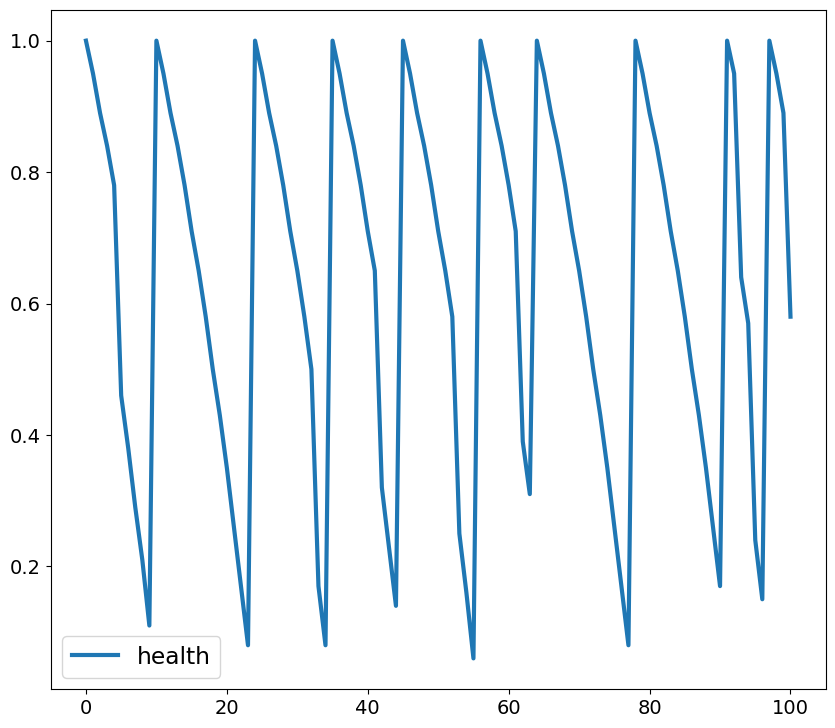

In [3]:
# Visualize Exponential Degradation
import gym
import pickle
import pandas as pd
import random
store = []
diag_model = pickle.load(open('diagnostics/model_' + 'pn' + str(0) + '_mn' + str(0), 'rb'))
env = gym.make('Production-v0', diag_model = diag_model, prod_levels = 5)
obs = env.reset()
done = False
store.append([1])
#while not done:
for i in range(100):
    # Compute next state
    #action = random.choice([0, 1, 2, 3, 4])
    obs, reward, done, info = env.step(4)
    # Store results of this episode
    store.append([env.true_health])
eps_df = pd.DataFrame(store, columns=['health'])
eps_df.plot(y='health')

<AxesSubplot:>

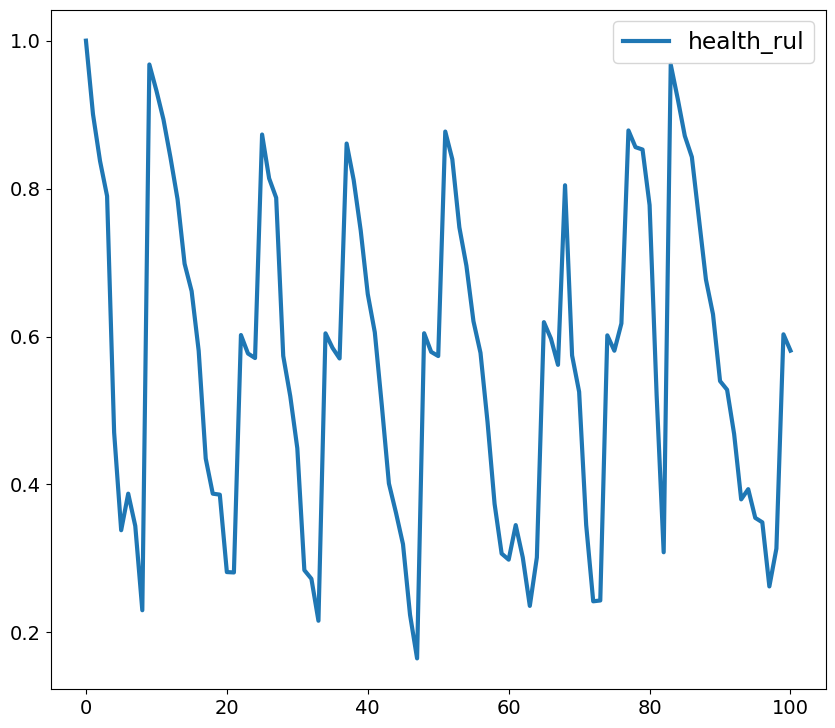

In [9]:
eps_df.plot(y='health_rul')

In [14]:
### REINFORCEMENT LEARNING III ###
### EVALUATE REACTIVE MODEL ###

import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3 import PPO
import numpy as np
import math
import gym

env = gym.make('Production-v0', reactive_mode = True, forecast = 0, prod_levels = 5)
# Initialize Reward
# Set iterations
iterations = 100
result_df = pd.DataFrame(np.nan, index=range(0,iterations), columns=['RM', 'PM', 'MTBF', 'Inventory', 'Spare Parts Inventory', 'Reward', 'Upper'])

for i in range(iterations):
    # Initialize episode
    store = []
    obs = env.reset()
    done = False
    store.append([0, env.true_health, env.breakdown, obs[0], obs[1], 0, done, env.old_order])
    # Compute one episode
    while not done:
        # Get best action for state
        action = min(env.prod_levels-1, max(0, round(env.old_order)))
        # Compute next state
        obs, reward, done, info = env.step(action)
        # Store results of this episode
        store.append([action, env.true_health, env.breakdown, obs[0], obs[1], reward, done, env.old_order])
    eps_df = pd.DataFrame(store, columns=['action', 'health', 'breakdown', 'inventory', 'sp_inventory', 'reward', 'done', 'old_order'])
    # Calculate nr. of reactive maintenance interventions by counting health 'resets' and substracting PM actions
    result_df.iloc[i]['RM'] = sum(eps_df['breakdown']==True)
    # Calculate nr. of preventive maintenance interventions
    result_df.iloc[i]['PM'] = sum(eps_df['action']== env.actions-1)
    # Calculate mean time between failures
    # Cut df after last breakdown
    eps_df_trim = eps_df.iloc[:(np.where(eps_df['breakdown'].eq(True), eps_df.index, 0).max()+1)]
    # Calculate MTBF by dividing periods where machine is running / breakdowns
    result_df.iloc[i]['MTBF'] = (len(eps_df_trim) - sum(eps_df_trim['breakdown'] == True)) / sum(eps_df_trim['breakdown'] == True)
    # Calculate inventory
    result_df.iloc[i]['Inventory'] = sum(eps_df['inventory'])
    # Calculate spare parts inventory per period
    result_df.iloc[i]['Spare Parts Inventory'] = sum(eps_df['sp_inventory'])
    # Calculate reward
    result_df.iloc[i]['Reward'] = sum(eps_df['reward'])
    # Calculate reward with no costs and fulfillment of all orders
    result_df.iloc[i]['Upper'] = sum(eps_df['old_order']) * env.order_r

print("The average number of reactive maintenance interventions per episode is: ", result_df['RM'].mean())
print("The average number of preventive maintenance interventions per episode is: ", result_df['PM'].mean())
print("The average mean time between failure per episode is: ", result_df['MTBF'].mean())
print("The standard deviation of the mean time between failure per episode is: ", result_df['MTBF'].std())
print("The average sum of inventory per episode is: ", result_df['Inventory'].mean())
print("The average sum of spare parts inventory per episode is: ", result_df['Spare Parts Inventory'].mean())
print("The average reward per episode is: ", result_df['Reward'].mean())
print("The average upper bound per episode is: ", result_df['Upper'].mean())

The average number of reactive maintenance interventions per episode is:  5.92
The average number of preventive maintenance interventions per episode is:  0.0
The average mean time between failure per episode is:  14.887095238095235
The standard deviation of the mean time between failure per episode is:  1.5405320836510183
The average sum of inventory per episode is:  114.34
The average sum of spare parts inventory per episode is:  0.0
The average reward per episode is:  317.37
The average upper bound per episode is:  2991.5


In [15]:
### REINFORCEMENT LEARNING IV ###
### EVALUATE TIME-BASED PREVENTIVE MODEL ###

import pandas as pd
import numpy as np
import gym
import math

env = gym.make('Production-v0', forecast = 0, prod_levels = 6)
interval = range (11, 12)
# Set iterations
iterations = 100

for k in interval:
    # Initilaize Reward
    result_df = pd.DataFrame(np.nan, index=range(0,100), columns=['RM', 'PM', 'Inventory', 'Spare Parts Inventory', 'Reward', 'Upper'])

    for i in range(iterations):
        # Initialize episode
        store = []
        obs = env.reset()
        done = False
        store.append([0, obs[0], env.breakdown, obs[1], obs[2], 0, done, env.old_order])
        # Compute one episode
        while not done:
            # One period before maintenance: action = order + spare part order
            if env.scheduled_maintenance_counter == k-1:
                action = min(env.prod_levels-1, max(0, round(env.old_order))) + env.prod_levels
            # At period of mtbf: maintain
            elif env.scheduled_maintenance_counter == k:
                action = env.actions-1
            # Else: action = order    
            else:             
                action = min(env.prod_levels-1, max(0, round(env.old_order)))
            # Compute next state
            obs, reward, done, info = env.step(action)
            # Store results of this episode
            store.append([action, obs[0], env.breakdown, obs[1], obs[2], reward, done, env.old_order])
        eps_df = pd.DataFrame(store, columns=['action', 'health', 'breakdown', 'inventory', 'sp_inventory', 'reward', 'done', 'old_order'])
        # Calculate nr. of reactive maintenance interventions by counting health 'resets' and substracting PM actions
        result_df.iloc[i]['RM'] = sum(eps_df['breakdown']==True)
        # Calculate nr. of preventive maintenance interventions
        result_df.iloc[i]['PM'] = sum(eps_df['action']==env.actions-1)
        # Calculate inventory
        result_df.iloc[i]['Inventory'] = sum(eps_df['inventory'])
        # Calculate spare parts inventory per period
        result_df.iloc[i]['Spare Parts Inventory'] = sum(eps_df['sp_inventory'])
        # Calculate reward
        result_df.iloc[i]['Reward'] = sum(eps_df['reward'])
        # Calculate reward with no costs and fulfillment of all orders
        result_df.iloc[i]['Upper'] = sum(eps_df['old_order']) * env.order_r

    print("\n", "Maintenance Interval: ", k, "Coefficient: ", 0+0.05*k)
    print("The average number of reactive maintenance interventions per episode is: ", result_df['RM'].mean())
    print("The average number of preventive maintenance interventions per episode is: ", result_df['PM'].mean())
    print("The average sum of inventory per episode is: ", result_df['Inventory'].mean())
    print("The average sum of spare parts inventory per episode is: ", result_df['Spare Parts Inventory'].mean())
    print("The average reward per episode is: ", result_df['Reward'].mean())
    print("The average upper bound per episode is: ", result_df['Upper'].mean())


 Maintenance Interval:  11 Coefficient:  0.55
The average number of reactive maintenance interventions per episode is:  1.65
The average number of preventive maintenance interventions per episode is:  6.57
The average sum of inventory per episode is:  156.97
The average sum of spare parts inventory per episode is:  6.63
The average reward per episode is:  1221.5
The average upper bound per episode is:  3010.1


In [10]:
### REINFORCEMENT LEARNING Va ###
### VISUALIZE STATE-ACTION ###
import numpy as np
state_action = []

# Define observation grid
grid_health = np.arange(0.0, 1.01, 0.01)
#grid_order = range(0, 5)
grid_inventory = range(0, 10)
grid_sp_inventory = [0, 1]

# Loop through grid and store best action for each state
for hlt in grid_health:
    #for ord in grid_order:
    for inv in grid_inventory:
        for sin in grid_sp_inventory:
            # Predict
            #action, _state = model.predict((hlt, ord, inv, sin), deterministic=True)
            #state_action.append([hlt, ord, inv, sin, action])
            action, _state = model.predict((hlt, inv, sin), deterministic=True)
            state_action.append([hlt, inv, sin, action])

#state_action_df = pd.DataFrame(state_action, columns=['health', 'order', 'inventory', 'sp_inventory', 'action'])
state_action_df = pd.DataFrame(state_action, columns=['health', 'inventory', 'sp_inventory', 'action'])
state_action_df.to_excel("./Rev1/visuals/state_action.xlsx") 

In [11]:
### REINFORCEMENT LEARNING Vb ###
### VISUALIZE STATE-VALUE ###
import numpy as np
state_value = []

# Define observation grid
grid_health = np.arange(0.0, 1.01, 0.01)
#grid_order = range(0, 5)
grid_inventory = range(0, 10)
grid_sp_inventory = [0, 1]

# Loop through grid and store best action for each state
for hlt in grid_health:
    #for ord in grid_order:
    for inv in grid_inventory:
        for sin in grid_sp_inventory:
            # Predict
            #obs, _ = model.policy.obs_to_tensor(hlt, ord, inv, sin)
            obs, _ = model.policy.obs_to_tensor(hlt, inv, sin)
            value = model.policy.predict_values(obs).item()
            #state_value.append([hlt, ord, inv, sin, value])
            state_value.append([hlt, inv, sin, value])

#state_value_df = pd.DataFrame(state_value, columns=['health', 'order', 'inventory', 'sp_inventory', 'value'])
state_value_df = pd.DataFrame(state_value, columns=['health', 'inventory', 'sp_inventory', 'value'])
state_value_df.to_excel("./Rev1/visuals/state_value.xlsx") 


TypeError: obs_to_tensor() takes 2 positional arguments but 4 were given

In [8]:
eps_df.to_excel("./Rev1/visuals/eps.xlsx") 